In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import numpy as np
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.autograd import Variable
import operator
import warnings
warnings.filterwarnings('ignore')
import os
from queue import PriorityQueue
import time
import math
import matplotlib.pyplot as plt
%matplotlib inline
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

from sacrebleu import raw_corpus_bleu

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
#Define constants here
PAD_TOKEN = 0
SOS_TOKEN = 1
EOS_TOKEN = 2
UNK_TOKEN = 3
BATCH_SIZE = 32
TEST_BATCH_SIZE = 3
words_to_load = 80000
emb_size = 300
wiki_size = 300
CUDA = True
MAX_LENGTH = 50

In [3]:
datadir = os.getcwd()
datadir
ftdir = '/scratch/yz4499/fasttext/'

### Load pretrained word embeddings:
Reference: https://fasttext.cc/docs/en/pretrained-vectors.html

@article{bojanowski2017enriching,
  title={Enriching Word Vectors with Subword Information},
  author={Bojanowski, Piotr and Grave, Edouard and Joulin, Armand and Mikolov, Tomas},
  journal={Transactions of the Association for Computational Linguistics},
  volume={5},
  year={2017},
  issn={2307-387X},
  pages={135--146}
}


In [36]:
#Reference Lab4 HW2
# datadir = os.getcwd()
words_to_load = 50000
# with open(datadir + '/data/wiki-news-300d-1M.vec') as f:
with open(ftdir + 'wiki-news-300d-1M.vec') as f:
    loaded_en_embeddings = np.zeros(((words_to_load+4), wiki_size))
    en_word2id = {}
    en_id2words = {}
    
    en_id2words[PAD_TOKEN] = '<PAD>'
    en_id2words[SOS_TOKEN] = '<SOS>'
    en_id2words[EOS_TOKEN] = '<EOS>'
    en_id2words[UNK_TOKEN] = '<UNK>'
    
    en_word2id['<PAD>'] = PAD_TOKEN
    en_word2id['<SOS>'] = SOS_TOKEN
    en_word2id['<EOS>'] = EOS_TOKEN
    en_word2id['<UNK>'] = UNK_TOKEN
    
    en_ordered_words= []
    en_ordered_words.append('<PAD>')
    en_ordered_words.append('<SOS>')
    en_ordered_words.append('<EOS>')
    en_ordered_words.append('<UNK>')
    
    for i, line in enumerate(f):
        if i >= words_to_load:
            break
        if i ==0:#Ignore the first line
            continue;
        s = line.split()
        #print(len(s))
        loaded_en_embeddings[i+4,:] = np.asarray(s[1:])
        en_word2id[s[0]] = i+4 #for extra pad and unk eos and unk
        en_id2words[i+4] = s[0]
        en_ordered_words.append(s[0])

In [37]:
#Reference Lab4 HW2
#Over 200000 loaded words, 58 has wrong dimensions
words_to_load = 50000
# datadir = os.getcwd()
with open(ftdir + 'cc.vi.300.vec') as f:
    loaded_vi_embeddings = np.zeros(((words_to_load+4),wiki_size))
    vi_word2id = {}
    vi_id2words = {}
    
    vi_id2words[PAD_TOKEN] = '<PAD>'
    vi_id2words[SOS_TOKEN] = '<SOS>'
    vi_id2words[EOS_TOKEN] = '<EOS>'
    vi_id2words[UNK_TOKEN] = '<UNK>'
    
    vi_word2id['<PAD>'] = PAD_TOKEN
    vi_word2id['<SOS>'] = SOS_TOKEN
    vi_word2id['<EOS>'] = EOS_TOKEN
    vi_word2id['<UNK>'] = UNK_TOKEN
    
    vi_ordered_words= []
    vi_ordered_words.append('<PAD>')
    vi_ordered_words.append('<SOS>')
    vi_ordered_words.append('<EOS>')
    vi_ordered_words.append('<UNK>')
    wrong_dim = 0;
    for i, line in enumerate(f):
        #print(line)
        if i >= words_to_load:
            break;
        if i == 0: #Ignore the first line
            continue;
        s = line.split()
        if len(s) != 301:
            wrong_dim += 1#Skip the wrong dimension one
            continue;
        loaded_vi_embeddings[i+4,:] = np.asarray(s[1:])
        vi_word2id[s[0]] = i+4 #for extra pad and unk 
        vi_id2words[i+4] = s[0]
        vi_ordered_words.append(s[0])
    print('In total {} has wrong dimension, hence skipped'.format(wrong_dim))

In total 0 has wrong dimension, hence skipped


In [6]:
# import pickle as pkl
# pkl.dump(loaded_zh_embeddings, open(ftdir+'zh_embeddings.p', 'wb'))
# pkl.dump(loaded_en_embeddings, open(ftdir+'en_embeddings.p', 'wb'))
# pkl.dump(loaded_vi_embeddings, open(ftdir+'vi_embeddings.p', 'wb'))

In [7]:
PAD_TOKEN = 0
SOS_TOKEN = 1
EOS_TOKEN = 2
UNK_TOKEN = 3
BATCH_SIZE = 3

class Lang:
    def __init__(self, name, emb_word2id, emb_id2word, emb_ordered_words):
        self.name = name
        self.word2index = emb_word2id
        self.word2count = {}
        self.index2word = emb_id2word #Dict
        self.n_words = 4  # Count SOS and EOS +(batch: pad and unk)

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2count:
            self.word2count[word] = 1
            self.n_words += 1
        else:
            self.word2count[word] += 1
            

# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

#Lowercase, trim, and remove non-letter characters
def normalizeString(s, lang):
    if lang == "en":
        s = s.replace("&apos;", "").replace("&quot;", "")
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    #This line is commented out since it will not properly deal with Chinese Letters
#     s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s = re.sub(r"\s+", r" ", s).strip()
    return s

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

#reference: LAB4 hw2
def indexesFromSentences(lang1, lang2, pairs):
    id_list1 = []
    id_list2 = []
    for i in range(len(pairs)):
        sentence1 = pairs[i][0]
        sentence2 = pairs[i][1]
        
        sentence1 = sentence1.replace('quot','')
        sentence1 = sentence1.replace('apos', '')
        sentence2 = sentence2.replace('quot','')
        sentence2 = sentence2.replace('apos', '')
        #If either sentence is empty, then remove the pair
        if sentence1 == '' or sentence2 == '':
            continue;
        
        id_sentence1 = [lang1.word2index[word] if word in lang1.word2index else UNK_TOKEN 
                        for word in sentence1.split()] + [EOS_TOKEN]
        id_list1.append(id_sentence1)
        id_sentence2 = [lang2.word2index[word] if word in lang2.word2index else UNK_TOKEN 
                        for word in sentence2.split()] + [EOS_TOKEN]
        id_list2.append(id_sentence2)
        
   
        
    return id_list1,id_list2

# def sentence2id(sentence_list):
#     id_list = []
#     for sentence in sentence_list:
#         sentence_id_list = [word2id[word] if word in word2id else UNK_IDX for word in sentence]
#         id_list.append(sentence_id_list)
#     return id_list

# def tensorFromSentence(lang, sentence):
#     indexes = indexesFromSentence(lang, sentence)
#     indexes.append(EOS_TOKEN)
#     return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


# def tensorsFromPair(pair):
#     input_tensor = tensorFromSentence(input_lang, pair[0])
#     target_tensor = tensorFromSentence(output_lang, pair[1])
#     return (input_tensor, target_tensor)


# def filterPair(p):
#     return len(p[0].split(' ')) < MAX_LENGTH and \
#         len(p[1].split(' ')) < MAX_LENGTH and \
#         p[1].startswith(eng_prefixes)


# def filterPairs(pairs):
#     return [pair for pair in pairs if filterPair(pair)]

In [8]:
def readLangs(lang1, lang2, category, reverse = False):#category = ['train', 'dev','test]
    print('Reading lines:')
    lines1 = open('data/iwslt-' + lang1.name +'-en/' + category +'.tok.'+ lang1.name, encoding = 'utf-8').\
    read().strip().split('\n')
    data1 = [normalizeString(l, lang1.name) for l in lines1]
    #data1 = list(filter(None, data1)) # fastest

    lines2 = open('data/iwslt-' + lang1.name +'-en/' + category + '.tok.' + lang2.name, encoding = 'utf-8').\
    read().strip().split('\n')
    data2 = [normalizeString(l, lang2.name) for l in lines2]
    #Given that data2 is english hence we further normalize
    data2 = [re.sub(r"[^a-zA-Z.!?]+", r" ", data) for data in data2]
    #data2 = list(filter(None, data2)) # fastest

    return data1, data2

In [9]:
#Data Preparation for CHN to ENG
def prepareData(lang1, lang2, category, reverse = False):
    data1, data2 = readLangs(lang1, lang2, category, reverse)#Read data returns list of sentences
    pairs = [[data1[i], data2[i]] for i in range(len(data1))]
    print('Read %s sentence pairs' % len(pairs))
    #Count the words
    print('Counting words')
    for i in range(len(pairs)):
        lang1.addSentence(data1[i])
        lang2.addSentence(data2[i])

    print('Counted Words')
    print(lang1.name, lang1.n_words)
    print(lang2.name, lang2.n_words)

    return pairs, data1, data2



In [10]:
#Create language object
# input_zh = Lang('zh', zh_word2id, zh_id2words, zh_ordered_words)
# output_zh_en = Lang('en', en_word2id, en_id2words, en_ordered_words)
input_vi = Lang('vi', vi_word2id, vi_id2words, vi_ordered_words)
output_vi_en = Lang('en', en_word2id, en_id2words, en_ordered_words)

In [11]:
#Create the string pairs and the string lists
# train_zh_pairs, zh_train, zh_en_train = prepareData(input_zh, output_zh_en, 'train')
# val_zh_pairs, zh_val, zh_en_val = prepareData(input_zh, output_zh_en, 'dev')
# test_zh_pairs, zh_test, zh_en_test = prepareData(input_zh, output_zh_en, 'test')

train_vi_pairs, vi_train, vi_en_train = prepareData(input_vi, output_vi_en, 'train')
val_vi_pairs, vi_val, vi_en_val = prepareData(input_vi, output_vi_en, 'dev')
test_vi_pairs, vi_test, vi_en_test = prepareData(input_vi, output_vi_en, 'test')

Reading lines:
Read 133317 sentence pairs
Counting words
Counted Words
vi 30768
en 41271
Reading lines:
Read 1268 sentence pairs
Counting words
Counted Words
vi 30916
en 41434
Reading lines:
Read 1553 sentence pairs
Counting words
Counted Words
vi 31057
en 41598


In [12]:
import random
random.choice(val_vi_pairs)

['khi toi 11 tuoi , toi nho mot buoi sang toi thuc_day khi nghe tieng han_hoan trong can nha cua toi .',
 'when i was i remember waking up one morning to the sound of joy in my house .']

In [13]:
# zh_idx_train, zh_en_idx_train = indexesFromSentences(input_zh, output_zh_en, train_zh_pairs)
# zh_idx_val, zh_en_idx_val = indexesFromSentences(input_zh, output_zh_en, val_zh_pairs)
# zh_idx_test, zh_en_idx_test = indexesFromSentences(input_zh, output_zh_en, test_zh_pairs)

vi_idx_train, vi_en_idx_train = indexesFromSentences(input_vi, output_vi_en, train_vi_pairs)
vi_idx_val, vi_en_idx_val = indexesFromSentences(input_vi, output_vi_en, val_vi_pairs)
vi_idx_test, vi_en_idx_test = indexesFromSentences(input_vi, output_vi_en, test_vi_pairs)


In [14]:
# zh_train_pairs = [[zh_idx_train[i], zh_en_idx_train[i]] for i in range(len(zh_idx_train))]
# zh_val_pairs = [[zh_idx_val[i], zh_en_idx_val[i]] for i in range(len(zh_idx_val))]
# zh_test_pairs= [[zh_idx_test[i], zh_en_idx_test[i]] for i in range(len(zh_idx_test))]
vi_train_pairs = [[vi_idx_train[i], vi_en_idx_train[i]] for i in range(len(vi_idx_train))]
vi_val_pairs = [[vi_idx_val[i], vi_en_idx_val[i]] for i in range(len(vi_idx_val))]
vi_test_pairs = [[vi_idx_test[i], vi_en_idx_test[i]] for i in range(len(vi_idx_test))]


In [15]:
len(vi_val_pairs)

1268

In [16]:
# import pickle as pkl
# pkl.dump(zh_train_pairs, open('./data/zh_train_pairs.p', 'wb'))
# pkl.dump(zh_val_pairs, open('./data/zh_val_pairs.p', 'wb'))
# pkl.dump(zh_test_pairs, open('./data/zh_test_pairs.p', 'wb'))

# pkl.dump(vi_train_pairs, open('./data/vi_train_pairs.p', 'wb'))
# pkl.dump(vi_val_pairs, open('./data/vi_val_pairs.p', 'wb'))
# pkl.dump(vi_test_pairs, open('./data/vi_test_pairs.p', 'wb'))


In [17]:
max_val_len = 0
second_len = 0
for pair in vi_val_pairs:
    if max_val_len < len(pair[0]):
        second_len = max_val_len
        max_val_len = len(pair[0])

print(max_val_len, second_len)

110 104


In [18]:
#For training data, we have max-len as 100: train: 133038/133316, val: 1268/1268, test: 1553/1553
#For training data, we have max-len as 80: train: 132789/133316, val: 1267/1268, test: 1552/1553
vi_train_pairs_cleaned= []
vi_val_pairs_cleaned = []
vi_test_pairs_cleaned = []
MAX_LENGTH = 80
for vi_list in vi_train_pairs:
    if len(vi_list[0])<=MAX_LENGTH and len(vi_list[1]) <= MAX_LENGTH:
        vi_train_pairs_cleaned.append(vi_list)
        
for vi_list in vi_val_pairs:
    if len(vi_list[0])<=MAX_LENGTH and len(vi_list[1]) <= MAX_LENGTH:
        vi_val_pairs_cleaned.append(vi_list)

for vi_list in vi_test_pairs:
    if len(vi_list[0])<=MAX_LENGTH and len(vi_list[1]) <= MAX_LENGTH:
        vi_test_pairs_cleaned.append(vi_list)


In [19]:
len(vi_train_pairs)

133166

In [20]:
len(vi_train_pairs_cleaned)

132318

In [21]:
len(vi_val_pairs)

1268

In [22]:
len(vi_val_pairs_cleaned)

1262

In [23]:
len(vi_test_pairs)

1553

In [24]:
len(vi_test_pairs_cleaned)

1549

In [25]:
# import pickle as pkl
# # pkl.dump(zh_train_pairs_cleaned, open('./data/zh_train_pairs_cleaned.p', 'wb'))
# # pkl.dump(zh_val_pairs_cleaned, open('./data/zh_val_pairs_cleaned.p', 'wb'))
# # pkl.dump(zh_test_pairs_cleaned, open('./data/zh_test_pairs_cleaned.p', 'wb'))

# pkl.dump(vi_train_pairs_cleaned, open('./data/vi_train_pairs_cleaned.p', 'wb'))
# pkl.dump(vi_val_pairs_cleaned, open('./data/vi_val_pairs_cleaned.p', 'wb'))
# pkl.dump(vi_test_pairs_cleaned, open('./data/vi_test_pairs_cleaned.p', 'wb'))


In [26]:
# import pickle as pkl
# #loading data
# # zh_train_pairs_cleaned = pkl.load(open('./data/zh_train_pairs_cleaned.p', 'rb'))
# # zh_val_pairs_cleaned = pkl.load(open('./data/zh_val_pairs_cleaned.p', 'rb'))
# # zh_test_pairs_cleaned = pkl.load(open('./data/zh_test_pairs_cleaned.p', 'rb'))

# vi_train_pairs_cleaned = pkl.load(open('./data/vi_train_pairs_cleaned.p', 'rb'))
# vi_val_pairs_cleaned = pkl.load(open('./data/vi_val_pairs_cleaned.p', 'rb'))
# vi_test_pairs_cleaned = pkl.load(open('./data/vi_test_pairs_cleaned.p', 'rb'))

In [27]:
class NMTDataset(Dataset):
    def __init__(self, pairs):#Needs the index pairs
        self.pairs = pairs
#         self.input_lang = input_lang
#         self.output_lang = output_lang
        self.input_seqs = [pairs[i][0] for i in range(len(self.pairs))]
        self.output_seqs = [pairs[i][1] for i in range(len(self.pairs))]

    def __len__(self):
        return len(self.pairs)#Returning number of pairs
    
    def __getitem__(self, index):
        input_seq = self.input_seqs[index]
        output_seq = self.output_seqs[index]
        return [input_seq, len(input_seq), output_seq, len(output_seq)]
    
def vocab_collate_func(batch):
    #Reference: lab8_3_mri
    def _pad_sequences(seqs):
        lens = [len(seq) for seq in seqs]
#         padded_seqs = torch.zeros(len(seqs), max(lens)).long()
        padded_seqs = torch.zeros(len(seqs), MAX_LENGTH).long()
        for i, seq in enumerate(seqs):
            end = lens[i]
            padded_seqs[i, :end] = torch.LongTensor(seq[:end])
        return padded_seqs, lens
    
    batch_input_seqs = [datum[0] for datum in batch]
    batch_output_seqs = [datum[2] for datum in batch]
    #batch_input_length = [datum[1] for datum in batch]
    #batch_output_length = [datum[3] for datum in batch]

    sorted_pairs = sorted(zip(batch_input_seqs, batch_output_seqs), key=lambda x: len(x[0]), reverse = True)
    in_seq_sorted, out_seq_sorted = zip(*sorted_pairs)
    
    padded_input,input_lens = _pad_sequences(in_seq_sorted)
    padded_output,output_lens = _pad_sequences(out_seq_sorted)
    
    input_list = torch.from_numpy(np.array(padded_input))
    input_length = torch.LongTensor(input_lens)
    output_list = torch.from_numpy(np.array(padded_output))
    output_length = torch.LongTensor(output_lens)
    
    if CUDA:
        input_list = input_list.cuda()
        output_list = output_list.cuda()
        input_length = input_length.cuda()
        output_length = output_length.cuda()
            
    return [input_list, input_length, output_list, output_length]

In [28]:
BATCH_SIZE = 32
'''
NMTDataset needs index pairs, need to call indexesFromPairs functions beforehand
The dataLoader is sorted according to length of the input_length, and padded to
max length of input and output list repectively
TODO: output_list is not sorted, hence need to sort (maybe) in the rnn sequence.
'''
# train_zh_dataset = NMTDataset(zh_train_pairs_cleaned, input_zh, output_zh_en)
# train_vi_dataset = NMTDataset(vi_train_pairs_cleaned, input_vi, output_vi_en)
# val_zh_dataset = NMTDataset(zh_val_pairs_cleaned, input_zh, output_zh_en)
# val_vi_dataset = NMTDataset(vi_val_pairs_cleaned, input_vi, output_vi_en)
# test_zh_dataset = NMTDataset(zh_test_pairs_cleaned, input_zh, output_zh_en)
# test_vi_dataset = NMTDataset(vi_test_pairs_cleaned, input_vi, output_vi_en)

# train_zh_dataset = NMTDataset(zh_train_pairs_cleaned)
train_vi_dataset = NMTDataset(vi_train_pairs_cleaned)
# val_zh_dataset = NMTDataset(zh_val_pairs_cleaned)
val_vi_dataset = NMTDataset(vi_val_pairs_cleaned)
# test_zh_dataset = NMTDataset(zh_test_pairs_cleaned)
test_vi_dataset = NMTDataset(vi_test_pairs_cleaned)


# train_zh_loader = torch.utils.data.DataLoader(dataset = train_zh_dataset, 
#                                           batch_size = BATCH_SIZE,
#                                           collate_fn = vocab_collate_func,
#                                           shuffle = True)

train_vi_loader = torch.utils.data.DataLoader(dataset = train_vi_dataset, 
                                          batch_size = BATCH_SIZE,
                                          collate_fn = vocab_collate_func,
                                          shuffle = True)

#Will use batch size 1 for validation and test since the sentence will be translated one by one
# val_zh_loader = torch.utils.data.DataLoader(dataset = val_zh_dataset, 
#                                           batch_size = 1,
#                                           collate_fn = vocab_collate_func,
#                                           shuffle = False)
val_vi_loader = torch.utils.data.DataLoader(dataset = val_vi_dataset, 
                                          batch_size = 1,
                                          collate_fn = vocab_collate_func,
                                          shuffle = False)
# test_zh_loader = torch.utils.data.DataLoader(dataset = test_zh_dataset, 
#                                           batch_size = 1,
#                                           collate_fn = vocab_collate_func,
#                                           shuffle = False)
test_vi_loader = torch.utils.data.DataLoader(dataset = test_vi_dataset, 
                                          batch_size = 1,
                                          collate_fn = vocab_collate_func,
                                          shuffle = False)
#Input_batch in size Batch x maxLen


In [29]:
# for i, (input_list, input_length, output_list, output_length) in enumerate(val_zh_loader):
#     if i== 0:
#         break

In [30]:
# output_list

In [31]:
# input_list

In [32]:
# output_list.size()

### Batch encoder and decoder

In [33]:
#Here for the constant definition
# MAX_SENTENCE_LENGTH = 10
hidden_size = 256
max_length = 10
BATCH_SIZE = 3
TEST_BATCH_SIZE = 3
CLIP = 50
TEACHER_RATIO = 0.5


In [34]:
# import pickle as pkl
# #loading data
# # loaded_zh_embeddings = pkl.load(open(ftdir+'zh_embeddings.p', 'rb'))
# loaded_vi_embeddings = pkl.load(open(ftdir+'vi_embeddings.p', 'rb'))
# loaded_en_embeddings = pkl.load(open(ftdir+'en_embeddings.p', 'rb'))

In [38]:
# CUDA = False
# loaded_zh_embeddings = torch.from_numpy(loaded_zh_embeddings).float()
loaded_vi_embeddings = torch.from_numpy(loaded_vi_embeddings).float()
loaded_en_embeddings = torch.from_numpy(loaded_en_embeddings).float()

if CUDA:
#     loaded_zh_embeddings = loaded_zh_embeddings.cuda()
    loaded_vi_embeddings = loaded_vi_embeddings.cuda()
    loaded_en_embeddings = loaded_en_embeddings.cuda()


### Decoder with Attention

In [39]:
class EncoderRNN(nn.Module):
    def __init__(self, hidden_size, embed_size=emb_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding.from_pretrained(loaded_vi_embeddings, freeze=True)
        self.gru = nn.GRU(embed_size, hidden_size, batch_first=True)

    def forward(self, input_list, hidden):
        embedded = self.embedding(input_list)
#         packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, input_lengths)
#         output, hidden = self.gru(packed, hidden)
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def initHidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)

In [43]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, embed_size=emb_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.embedding = nn.Embedding.from_pretrained(loaded_en_embeddings, freeze=True)
        self.gru = nn.GRU(embed_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input)        
        output = F.relu(output)        
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        
        return output, hidden

    def initHidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size, device=device)

In [46]:
hidden_size = 300
encoder_test = EncoderRNN(hidden_size).to(device)
decoder_test = DecoderRNN(hidden_size, len(vi_ordered_words)).to(device)
criterion = nn.NLLLoss()

for i, (input_list,input_length,output_list, output_length) in enumerate(train_vi_loader):
    batch_size, max_input_length = input_list.size()
    max_output_length = output_list.size(1)
            
    encoder_hidden = encoder_test.initHidden(batch_size)
    encoder_output, encoder_hidden = encoder_test(input_list, encoder_hidden)
#     encoder_output, encoder_hidden = batch_encoder(input_list, input_length, encoder_hidden)
    
    decoder_input = torch.tensor(np.array([[SOS_TOKEN]] * batch_size).reshape(1, batch_size), device=device)
#     decoder_input = torch.tensor([[SOS_TOKEN]]*batch_size, device=device)
    decoder_hidden = encoder_hidden
#     decoder_hidden = encoder_hidden[:batch_decoder.n_layers]

    loss = 0
    for di in range(max_output_length):

        decoder_output, decoder_hidden = decoder_test(
            decoder_input, decoder_hidden)


        loss += criterion(decoder_output, output_list[:,di])
        decoder_input = output_list[:,di].unsqueeze(0) 
    loss.backward()
    
    break

### Training

In [83]:
#Referenced from lab8 1nmt and modified 
teacher_forcing_ratio = 0.5
def batch_train(input_list, input_length, output_list,output_length, 
                batch_encoder, batch_decoder, encoder_optimizer, decoder_optimizer, criterion):
    '''
    param: @attention is a Boolean variable indicating whether using attention
    '''
    batch_encoder.train()
    batch_decoder.train()
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    batch_size, max_input_length = input_list.size()
    max_output_length = output_list.size(1)
    
#     batch_size = input_list.size(0)
    
    loss = 0
    
    encoder_hidden = batch_encoder.initHidden(batch_size)

    encoder_outputs, encoder_hidden = batch_encoder(input_list, encoder_hidden)

    #Initialize for decoding process
    curr_batch = input_list.size(0)#Take the current batch size
    decoder_input = torch.tensor(np.array([[SOS_TOKEN]] * batch_size).reshape(1, batch_size), device=device)
    
#     decoder_hidden = encoder_hidden[:batch_decoder.n_layers]#Bidirectional summoned
    decoder_hidden = encoder_hidden
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        for di in range(max_output_length):
            decoder_output, decoder_hidden = batch_decoder(
                decoder_input, decoder_hidden)
            decoder_input = output_list[:,di].unsqueeze(0)
            loss += criterion(decoder_output, output_list[:,di])

    else:
        for di in range(max_output_length):
            decoder_output, decoder_hidden = batch_decoder(
                decoder_input, decoder_hidden)
            
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach().unsqueeze(0)
            loss += criterion(decoder_output, output_list[:,di])
            
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item()

In [48]:
hidden_size = 300
learning_rate = 0.01

encoder = EncoderRNN(hidden_size).to(device)
decoder = DecoderRNN(hidden_size, len(vi_ordered_words)).to(device)
encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
criterion = nn.NLLLoss()

for i, (input_list,input_length,output_list, output_length) in enumerate(train_vi_loader):
    loss = batch_train(input_list, input_length, output_list, output_length, encoder,
                         decoder, encoder_optimizer, decoder_optimizer, criterion)
    break

In [75]:
#Reference lab8 1-nmt
def greedy_evaluate(val_loader, encoder, decoder, en_id2words ):
    #Will generate sentences 1 by 1. 
    """
    Function that generate translation.
    First, feed the source sentence into the encoder and obtain the hidden states from encoder.
    Secondly, feed the hidden states into the decoder and unfold the outputs from the decoder.
    Lastly, for each outputs from the decoder, collect the corresponding words in the target language's vocabulary.
    And collect the attention for each output words.
    @param encoder: the encoder network
    @param decoder: the decoder network
    @param sentence: string, a sentence in source language to be translated
    @param max_length: the max # of words that the decoder can return
    @output decoded_words: a list of words in target language
    @output decoder_attentions: a list of vector, each of which sums up to 1.0
    """    
    # process input sentence
    decoded_words_all = []
              
    with torch.no_grad():
        encoder.eval()
        decoder.eval()
        
        for i, (input_list, input_length, output_list, output_length) in enumerate(val_loader):
            if i %100 == 0:
                print("%d/%d"%(i,len(val_loader)))
                
            batch_size, max_input_length = input_list.size()
            max_output_length = output_list.size(1)
            
            #    break
            #batch_size, max_len = output_list.size()
#             print(input_list.size())

#         encoder_hidden = batch_encoder.initHidden(batch_size)

#     encoder_outputs, encoder_hidden = batch_encoder(input_list, encoder_hidden)

#     #Initialize for decoding process
#     curr_batch = input_list.size(0)#Take the current batch size
#     decoder_input = torch.tensor(np.array([[SOS_TOKEN]] * batch_size).reshape(1, batch_size), device=device)
    
# #     decoder_hidden = encoder_hidden[:batch_decoder.n_layers]#Bidirectional summoned
#     decoder_hidden = encoder_hidden
            
            encoder_hidden = encoder.initHidden(batch_size)
            encoder_outputs, encoder_hidden = encoder(input_list, encoder_hidden)

            decoder_input = torch.tensor(np.array([[SOS_TOKEN]] * batch_size).reshape(1, batch_size), device=device)
#             decoder_input = torch.tensor([[SOS_TOKEN]], device=device)  # SOS
            # decode the context vector
            decoder_hidden = encoder_hidden
#             decoder_hidden = encoder_hidden[:decoder.n_layers] # decoder starts from the last encoding sentence
            # output of this function
            decoded_words = []

            for di in range(MAX_LENGTH):
                # for each time step, the decoder network takes two inputs: previous outputs and the previous hidden states
                decoder_output, decoder_hidden = decoder(decoder_input.reshape(1, batch_size), decoder_hidden)

                top_score, topi = decoder_output.data.topk(1)
                decoded_words.append(en_id2words[topi.item()])
                if topi.item() == EOS_TOKEN:
                    break
                else:
                    decoder_input = topi.squeeze().detach().unsqueeze(0)
                    
            decoded_words_all.append(decoded_words)

        return decoded_words_all

In [60]:
# decoded_words_all, decoder_attention_all = greedy_attn_evaluate(val_zh_loader, pre_encoder, attn_decoder, en_id2words)

In [61]:
def post_process(decoded_words_all):
    cleaned_decoded_words_all = []
    
    for sentence in decoded_words_all:
        cleaned_sentence = []
        for word in sentence:
            if word == '<PAD>':
                continue
            else:
                cleaned_sentence.append(word)
        if cleaned_sentence[-1] != '<EOS>':
            cleaned_sentence.append(' <EOS>')
            
        cleaned_decoded_words_all.append(cleaned_sentence)
        
    return cleaned_decoded_words_all

In [62]:
#Translate the test and val lists back to english
def en_translate(index_list, en_id2words):
    translated_sentence_list = []
    for sentence in index_list:
        translated_sentence = []
        for index in sentence:
            translated_sentence.append(en_id2words[index])
        #translated_sentence.append('<EOS>')
        translated_sentence_list.append(translated_sentence)
    return translated_sentence_list

In [63]:
# decoded_words_list = post_process(decoded_words_all)

In [64]:
# decoded_words_list[0]

In [65]:
vi_en_val_list = [pair[1] for pair in vi_val_pairs_cleaned]
translated_sentence_list = en_translate(vi_en_val_list, en_id2words)
translated_sentence_list[0]

['when',
 'i',
 'was',
 'little',
 'i',
 'thought',
 'my',
 'country',
 'was',
 'the',
 'best',
 'on',
 'the',
 'planet',
 'and',
 'i',
 'grew',
 'up',
 'singing',
 'a',
 'song',
 'called',
 'nothing',
 'to',
 'envy',
 '.',
 '<EOS>']

In [80]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # put ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [84]:
#Reference LAB8 1-nmt
model_path = './model/'
def TrainIters(train_loader, val_loader, encoder, decoder, n_iters, val_translated_list,
                   print_every=100, plot_every=100, eval_every=500, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    
    criterion = nn.NLLLoss()
    
    epoch = 0
    epoch_total = n_iters*len(train_loader)
    
#     loss = 0
    
    for iter in range(n_iters):
        print_loss_total = 0  # Reset every print_every
        plot_loss_total = 0  # Reset every plot_every
        #print("Epoch {}/{}".format(i+1, n_epochs))
        for i, (input_list,input_length,output_list, output_length) in enumerate(train_loader):
            loss = batch_train(input_list, input_length, output_list, output_length, encoder,
                         decoder, encoder_optimizer, decoder_optimizer, criterion)
        
            print_loss_total += loss
            plot_loss_total += loss
            
#             if i > 0 and i % eval_every == 0:
#                 decoded_val, decoder_attentions = greedy_attn_evaluate(val_loader, encoder, decoder, en_id2words)
#                 decoded_clean = post_process(decoded_val)
#                 print('bleu score is {}'.format(raw_corpus_bleu(decoded_val, val_translated_list).score))

            if i > 0 and i % print_every == 0:
                print_loss_avg = print_loss_total / print_every
                print_loss_total = 0
                print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / epoch_total),
                                             epoch, epoch / epoch_total * 100, print_loss_avg))

            if i > 0 and i % plot_every == 0:
                plot_loss_avg = plot_loss_total / plot_every
                plot_losses.append(plot_loss_avg)
                plot_loss_total = 0
                
            epoch += 1
            
        torch.save(encoder.state_dict(), model_path + "encoder_rnn_"+str(start)+".pth")
        torch.save(decoder.state_dict(), model_path + "decoder_rnn_"+str(start)+".pth")

    showPlot(plot_losses)
    return plot_losses

1m 4s (- 87m 53s) (100 1%) 96.2952
2m 8s (- 86m 33s) (200 2%) 97.6171
3m 12s (- 85m 17s) (300 3%) 96.1381
4m 16s (- 84m 0s) (400 4%) 90.3176
5m 20s (- 82m 56s) (500 6%) 93.8625
6m 24s (- 81m 52s) (600 7%) 96.0208
7m 28s (- 80m 48s) (700 8%) 95.6722
8m 32s (- 79m 43s) (800 9%) 92.9771
9m 36s (- 78m 42s) (900 10%) 99.5170
10m 40s (- 77m 39s) (1000 12%) 97.3434
11m 44s (- 76m 33s) (1100 13%) 95.1725
12m 48s (- 75m 28s) (1200 14%) 95.1142
13m 52s (- 74m 22s) (1300 15%) 91.1673
14m 56s (- 73m 19s) (1400 16%) 94.3412
16m 0s (- 72m 14s) (1500 18%) 92.9831
17m 4s (- 71m 9s) (1600 19%) 91.9231
18m 8s (- 70m 5s) (1700 20%) 94.9904
19m 12s (- 69m 2s) (1800 21%) 98.1314
20m 16s (- 67m 59s) (1900 22%) 95.4475
21m 20s (- 66m 54s) (2000 24%) 93.8922
22m 24s (- 65m 50s) (2100 25%) 95.0206
23m 28s (- 64m 46s) (2200 26%) 92.0465
24m 32s (- 63m 42s) (2300 27%) 96.4450
25m 36s (- 62m 37s) (2400 29%) 94.1764
26m 40s (- 61m 33s) (2500 30%) 95.6303
27m 44s (- 60m 29s) (2600 31%) 92.6721
28m 49s (- 59m 26s) (

<Figure size 432x288 with 0 Axes>

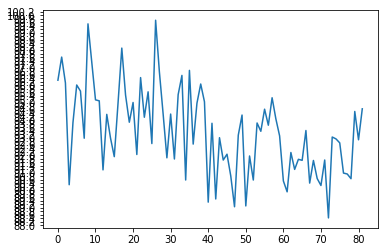

In [85]:
learning_rate = 0.001
hidden_size = 300

# encoder = EncoderRNN(hidden_size).to(device)
# decoder = DecoderRNN(hidden_size, len(vi_ordered_words)).to(device)
# pre_encoder = PreBatchEncoderRNN(loaded_vi_embeddings, emb_size, hidden_size, train_vi_loader.batch_size).to(device)
# attn_decoder = PreAttnDecoderRNN(loaded_en_embeddings, emb_size, hidden_size, len(en_ordered_words), train_vi_loader.batch_size).to(device)

plot_losses = TrainIters(train_vi_loader, val_vi_loader, encoder, decoder, 2,
               None, print_every=100, learning_rate=learning_rate)


In [86]:
np.save(model_path + "vi-loss", plot_losses)

In [87]:
decoded_val = greedy_evaluate(val_vi_loader, encoder, decoder, en_id2words)
decoded_clean = post_process(decoded_val)

0/1262
100/1262
200/1262
300/1262
400/1262
500/1262
600/1262
700/1262
800/1262
900/1262
1000/1262
1100/1262
1200/1262


In [88]:
from sacrebleu import corpus_bleu,raw_corpus_bleu

def bleu_score(predicted_list,translated_list):
    predicted_list_nopad = []
    for ii in range(len(predicted_list)):
        line = ''
        for jj in predicted_list[ii]:
            if jj != '<pad>':
                line = line + ' ' + jj
        predicted_list_nopad.append(line)
    labels = []
    for ii in range(len(translated_list)):
        line = ''
        for jj in translated_list[ii]:
            if jj != '<pad>':
                line = line + ' ' + jj
        labels.append(line)
    #print(len(labels))
    #print(len(predicted_list_nopad))
    print('bleu score for test dataset:', corpus_bleu(predicted_list_nopad, [labels]).score)
    print('bleu score for test dataset [raw]:', raw_corpus_bleu(predicted_list_nopad, [labels]).score)

In [89]:
bleu_score(decoded_clean,translated_sentence_list)

bleu score for test dataset: 12.820060448125922
bleu score for test dataset [raw]: 3.4357083784199354


In [162]:
bleu_score(decoded_clean,translated_sentence_list)

bleu score for test dataset: 13.244067757436477
bleu score for test dataset [raw]: 3.1149446308128703


In [169]:
random.choice(decoded_clean)

['so', 'there', 's', 'this', '.', 'this', '.', '.', '<EOS>']

In [ ]:
torch.cuda.get_device_name(0)

In [ ]:
time = timer()
i = 0
for batch in train_zh_loader:
    i += 1
print(i)

NameError: name 'plot_losses' is not defined